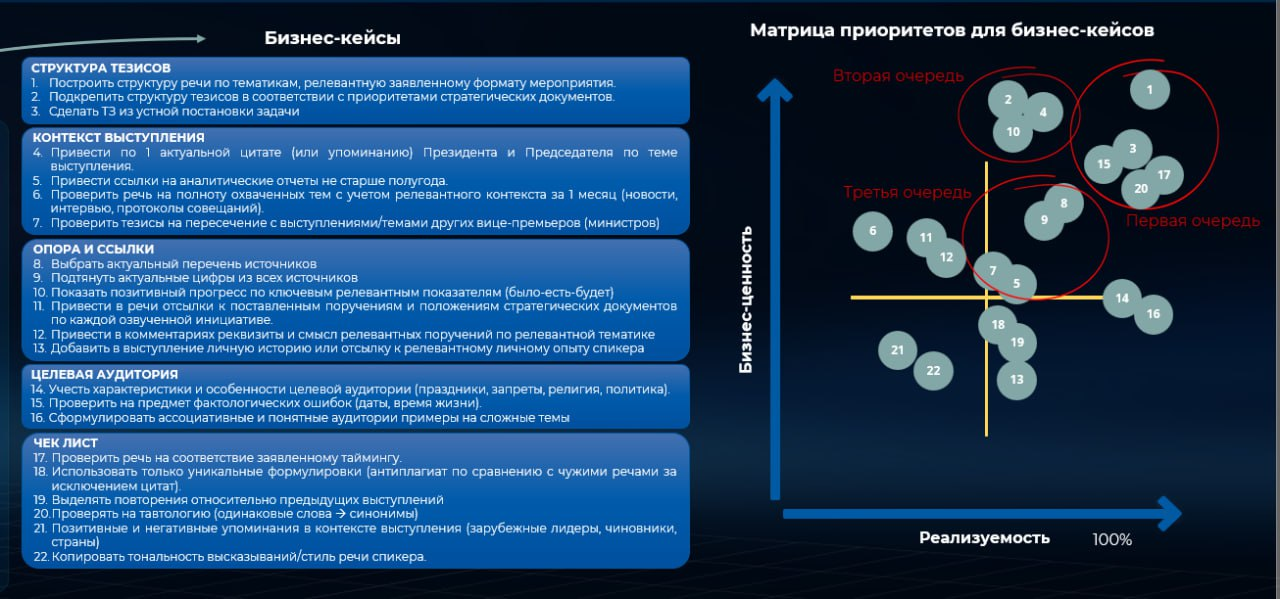

# Предварительная настройка и инициализация

In [33]:
!pip install langchain langchain_gigachat langchain_community langgraph langchain_chroma -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 2.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 628.3/628.3 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 48.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.6/278.6 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 43.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.2/93.2 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 77.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.8/54.8 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 4.9 MB/s eta 0:00:00
 

In [34]:
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

In [35]:
from langchain.prompts import ChatPromptTemplate
from langchain.schema.output_parser import StrOutputParser
from langchain_core.messages import HumanMessage
from langgraph.graph import END, START, MessagesState, StateGraph
from langgraph.types import interrupt
from typing import Literal, List, TypedDict, Annotated
from langgraph.types import Command
from langchain_core.output_parsers import JsonOutputParser
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_chroma import Chroma
import time

# Инициализируем подключение к GigaChat MAX

In [36]:
# Задайте логин и пароль для подключения к GigaChat.
# Вы также можете использовать другие способы авторизации.
# Подробнее о способах авторизации см. в документации к пакет gigachat:
# https://github.com/ai-forever/gigachat
from google.colab import userdata
giga_user = userdata.get('user')
giga_password = userdata.get('password')

In [37]:
from langchain_gigachat.chat_models.gigachat import GigaChat
from langchain_gigachat.embeddings import GigaChatEmbeddings

# LLM GigaChat
giga_low_topp = GigaChat(model="GigaChat-Max",
                verify_ssl_certs=False,
                profanity_check=False,
                password=giga_password,
                user=giga_user,
                base_url="https://gigachat.sberdevices.ru/v1",
                top_p=0,
                streaming=True,
                max_tokens=8000,
                timeout=600)

# Эмбеддер GigaChat
giga_embed = GigaChatEmbeddings(
                    scope="GIGACHAT_API_PERS",
                    verify_ssl_certs=False,
                    password=giga_password,
                    user=giga_user,
                    base_url="https://gigachat.sberdevices.ru/v1",
    )

# Загружаем и распознаем документы

In [38]:
import requests

files = ['ukaz_309.md', 'burnaev.md', 'president_speech.md']
all_content = {}

for file_path in files:
  url = f'https://raw.githubusercontent.com/Rai220/speech_writer/refs/heads/main/dataset/{file_path}'

  response = requests.get(url, stream=True)
  if response.status_code == 200:
      with open(file_path, 'wb') as file:
          for chunk in response.iter_content(chunk_size=8192):
              file.write(chunk)
  else:
      print(f"Не удалось скачать файл. Статус код: {response.status_code}")

  # Открываем и читаем содержимое файла
  with open(file_path, "r", encoding="utf-8") as file:
      content = file.read()

  print(f"Размер файла {file_path} - {len(content)} байт")
  all_content[file_path] = content

Размер файла ukaz_309.md - 23323 байт
Размер файла burnaev.md - 6072 байт
Размер файла president_speech.md - 202920 байт


## Инициализируем RAG

In [39]:
splitter = RecursiveCharacterTextSplitter(
    chunk_size=1200,
    chunk_overlap=350,
    length_function=len,
    keep_separator=True
)
chunks = splitter.split_text(all_content['president_speech.md'])
print(f"Количество чанков: {len(chunks)}")

Количество чанков: 236


In [41]:
vectorstore = Chroma.from_texts(chunks, embedding = giga_embed)

# Описываем агентов

## Главное состояние графа

In [7]:
class SpeechWriterState(MessagesState):
  speech_topic: str
  time_to_speak: str
  speech_plan: str
  speaker_bio: str
  result_speech: str
  critique: list[str]

# Агент-планировщик

In [8]:
def plan_speech(state: SpeechWriterState):
    TEMPLATE = """
Ты - агент-аналитик, который занимается помощью в составлении отличных речей для политиков.
Ты должен помочь спичрайтеру написать хорошую речь, поэтому ты должен составить техническое задание на написание речи
Тема выступления - {speech_topic}. Время выступления - {time_to_speak}.

Вот биография спикера для которого нужно написать речь:
<BIO>
{speaker_bio}
</BIO>

Вот документ на основании которого нужно написать речь:
<MAIN_DOCUMENT>
{content}
</MAIN_DOCUMENT>

Вот дополнительные документы, которые нужно учесть при составлении речи:
<ADDITIONAL_DOCUMENTS>
{additional_content}
</ADDITIONAL_DOCUMENTS>

Твой ответ должен быть в формате JSON:

**Формат вывода:**
```JSON
{{
  "speech_structure": "<структура речи по тематикам, релевантную заявленному формату мероприятия>",
  "tezis_structure: "<структуру тезисов в соответствии с приоритетами стратегических документов.>",
  "speech_tz: "<тз на написание речи>",
  "actual_citations: "<актуальные цитаты из исходных документов по теме выступления>"
}}```
    """
    print(f"📝 Speech planner начинает работу")
    chat_template = ChatPromptTemplate.from_messages(
        [
            ("system", TEMPLATE),
        ]
    )

    pipe = chat_template | giga_low_topp | StrOutputParser()

    resp = pipe.invoke(
        {
            "speech_topic": state["speech_topic"],
            "time_to_speak": state["time_to_speak"],
            "content": all_content['ukaz_309.md'],
            "additional_content": all_content['burnaev.md'],
            "speaker_bio": state["speaker_bio"]
        }
    )

    # printmd(f"Составлен план документа:\n{resp}")

    return {
        "speech_plan": resp
    }

## Агент-спичрайтер

In [19]:
def write_speech(state: SpeechWriterState):
    TEMPLATE = """
Ты - агент-спичрайтер. Ты должен написать речь для политиков на основании данных тебе документов.
Тема выступления - {speech_topic}. Время выступления - {time_to_speak}.

Вот биография спикера для которого нужно написать речь:
<BIO>
{speaker_bio}
</BIO>

Вот документ на основании которого нужно написать речь:
<MAIN_DOCUMENT>
{content}
</MAIN_DOCUMENT>

Вот дополнительные документы, которые нужно учесть при составлении речи:
<ADDITIONAL_DOCUMENTS>
{additional_content}
</ADDITIONAL_DOCUMENTS>

План выступления и вспомогательные инструкции от твоего коллеги-планировщика:
<SPEECH_PLAN>
{speech_plan}
</SPEECH_PLAN>

Вот предыдущая версия речи, которую ты написал на прошлой итерации (если есть):
<SPEECH_TEXT>
{result_speech}
<SPEECH_TEXT>

Вот конструктивная критика твоей предыдущей версии речи (если есть):
<CRITIQUE>
{critique}
</CRITIQUE>

Итоговая речь должна быть красиво оформлена в формате Markdown и представлять собой набор пунктов.
Если это речь для награждения - держи интригу, не называй победителя сразу.
Укажи время чтения в скобках под заголовком.
"""

    chat_template = ChatPromptTemplate.from_messages(
        [
            ("system", TEMPLATE),
        ]
    )

    pipe = chat_template | giga_low_topp | StrOutputParser()

    critique = state.get("critique", [""])[-1]
    print(f"👨‍💻 Writer начинает работу")

    resp = pipe.invoke(
        {
            "speech_topic": state["speech_topic"],
            "time_to_speak": state["time_to_speak"],
            "content": all_content['ukaz_309.md'],
            "additional_content": all_content['burnaev.md'],
            "speech_plan": state["speech_plan"],
            "speaker_bio": state["speaker_bio"],
            "result_speech": state.get("result_speech", ""),
            "critique": critique
        }
    )

    return {
        "result_speech": resp
    }

# Агент-критик

In [50]:
def critique(state: SpeechWriterState) -> Command[Literal["👨‍💻 Writer", "🌐 Retriever", END]]:
    TEMPLATE = """
Ты - агент-выпускающий редактор, который занимается помощью в составлении отличных речей для политиков. Ты должен оценить речь и решить - готова ли она или её нужно доработать.
Ты должен помочь спичрайтеру написать хорошую речь, твоя задача качественно оценить написанную речь и дать конструктивную обратную свзяь, если она требуется.

Ты должен дать ограниченное количество критики. В какой-то момент нужно остановиться и завершить написание речи.
Тема выступления - {speech_topic}. Время выступления - {time_to_speak}.

Вот биография спикера для которого нужно написать речь:
<BIO>
{speaker_bio}
</BIO>

Вот документ на основании которого нужно написать речь:
<MAIN_DOCUMENT>
{content}
</MAIN_DOCUMENT>

Вот дополнительные документы, которые нужно учесть при составлении речи:
<ADDITIONAL_DOCUMENTS>
{additional_content}
</ADDITIONAL_DOCUMENTS>

Вот текущий текст речи, который тебе надо оценить:
<SPEECH_TEXT>
{result_speech}
<SPEECH_TEXT>

Вот критика, которую ты давал ранее на предыдущие версии речи (если есть). Не повторяйся, не пиши ту же самую критику заново.
<OLD_CRITIQUE>
{old_critique}
</OLD_CRITIQUE>
Если ты не можешь дать никакой принципиально новой критики - прими решение good.
Текст обязательно должен содержать цитаты Путина. Если это не так, то в качестве финального решения прими решение retrieve

Твой ответ должен быть в формате JSON:

**Формат вывода:**
```JSON
{{
  "thoughts": "<твои мысли по поводу написанной речи>",
  "critique": "<конструктивная критика речи - что нужно поправить или доработать>",
  "is_new_critique": "<есть ли в твоей критики что-то принципиально новое, если сравнивать со старой критикой (если она была)> - True или False",
  "final_decision: "итоговое решение, должно быть одно из следующих: - good (если нет новой критики и речь закончена), fix (если требуется переписать речь), ask_human (если есть вопросы к человеку), retrieve (если требуется поиск в базе знаний)",
}}```
    """

    chat_template = ChatPromptTemplate.from_messages(
        [
            ("system", TEMPLATE),
        ]
    )

    pipe = chat_template | giga_low_topp | JsonOutputParser()

    print(f"🧑‍⚖️ Critic начинает работу")

    resp = pipe.invoke(
        {
            "speech_topic": state["speech_topic"],
            "time_to_speak": state["time_to_speak"],
            "content": all_content['ukaz_309.md'],
            "additional_content": all_content['burnaev.md'],
            "speaker_bio": state["speaker_bio"],
            "result_speech": state.get("result_speech", ""),
            "old_critique": state.get("critique", [])
        }
    )

    final_decision = resp.get("final_decision", "good")
    critique = resp.get("critique", "")
    is_new_critique = resp.get("is_new_critique", "False")
    # printmd(f"Составлена критика документа:\n{resp}")
    print(f"Критик принял решение: {final_decision}")

    old_critique = state.get("critique", [])
    old_critique.append(critique)
    update = {
      "critique": old_critique
    }

    goto = END
    # if final_decision == "fix" and is_new_critique:
    #   goto = "👨‍💻 Writer"

    return Command(
        update=update,
        goto=goto
    )

## Другие агенты

In [54]:
def ask_human(state: SpeechWriterState) -> Command[Literal["👨‍💻 Writer", "🌐 Retriever", END]]:
    return Command(
        update={},
        goto=END
    )

def retriever(state: SpeechWriterState):
    return Command(
        update={},
        goto=END
    )

# Собираем граф

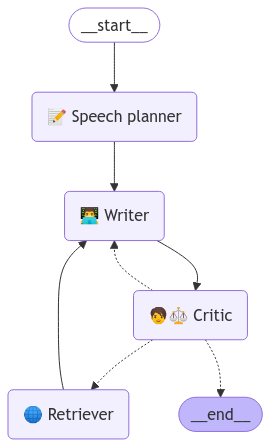

In [55]:
from langgraph.graph import END, START, MessagesState, StateGraph
from langgraph.checkpoint.memory import MemorySaver

builder = StateGraph(SpeechWriterState)
builder.add_node("📝 Speech planner", plan_speech)
builder.add_node("👨‍💻 Writer", write_speech)
builder.add_node("🧑‍⚖️ Critic", critique)
builder.add_node("🌐 Retriever", retriever)

builder.add_edge(START, "📝 Speech planner")
builder.add_edge("📝 Speech planner", "👨‍💻 Writer")
builder.add_edge("👨‍💻 Writer", "🧑‍⚖️ Critic")
builder.add_edge("🌐 Retriever", "👨‍💻 Writer")

memory = MemorySaver()
graph = builder.compile(checkpointer=memory)
graph

# Запускаем генерацию

In [23]:
speaker_bio = """Дмитрий Николаевич Чернышенко (род. 20 сентября 1968 года в Саратове) — российский государственный деятель и предприниматель. В 1993 году стал соучредителем одного из крупнейших в России коммуникационных холдингов Media Arts, которым управлял в течение 12 лет.
С 2007 по 2014 год занимал должность президента Организационного комитета XXII Олимпийских зимних игр и XI Паралимпийских зимних игр 2014 года в Сочи, сыграв ключевую роль в их подготовке и проведении.
В 2015 году возглавил АО «Газпром-Медиа Холдинг», где занимал пост генерального директора и председателя правления до 2020 года.
С 21 января 2020 года назначен заместителем председателя правительства Российской Федерации, курируя вопросы цифровой экономики, инноваций, связи, СМИ, а также культуры, туризма и спорта.
Чернышенко награжден орденом «За заслуги перед Отечеством» II степени, орденом Дружбы и орденом Почета.
Он увлекается горными лыжами и боевыми искусствами."""

inputs = {
    "speech_topic": "Награждение Евгения Бурнаева на Научной премии Сбера (номинация «Цифровая Вселенная»)",
    "time_to_speak": "5 минут",
    "speaker_bio": speaker_bio
}

config = {"configurable": {"thread_id": "1"}}
start = time.time()
for output in graph.stream(inputs, config=config, stream_mode="updates"):
  current_agent = next(iter(output))
  print(f"Отработал агент {current_agent}. Время: {int(time.time() - start)} с")

📝 Speech planner начинает работу
Отработал агент 📝 Speech planner. Время: 17 с
👨‍💻 Writer начинает работу
Отработал агент 👨‍💻 Writer. Время: 31 с
🧑‍⚖️ Critic начинает работу
Критик принял решение: fix
Отработал агент 🧑‍⚖️ Critic. Время: 36 с


In [24]:
printmd(graph.get_state(config=config).values['result_speech'])

# Награждение Евгения Бурнаева на Научной премии Сбера (номинация «Цифровая Вселенная») <br> (Время выступления: 5 минут)

---

**Открытие**

Уважаемые дамы и господа! Рад приветствовать вас сегодня на церемонии вручения Научной премии Сбера в номинации «Цифровая Вселенная». Эта премия отмечает выдающиеся достижения в области науки и технологий, и сегодня мы чествуем одного из самых ярких представителей нашего научного сообщества.

**Введение**

Сегодня мы собрались здесь, чтобы отметить вклад ученого, который внес значительный вклад в развитие технологий искусственного интеллекта и цифровую экономику нашей страны. Его работа открывает новые горизонты в решении сложных инженерных задач, делая наш мир более эффективным и безопасным.

**Основная часть**

1. **Важность вклада Евгения Бурнаева**: Евгений Бурнаев разработал методы на основе искусственного интеллекта, которые позволяют оптимизировать дизайн технических изделий и производить мониторинг состояния систем. Его подход сочетает в себе глубокое понимание теории и практические навыки, что делает его работу поистине уникальной.

2. **Практическая ценность применения ИИ**: Методы, предложенные Евгением Бурнаевым, находят применение в самых разных областях – от проектирования болидов Формулы-1 до создания эффективных косметических средств. Они помогают сократить расходы на эксперименты и повысить точность результатов, что имеет огромное значение для промышленности, медицины и других сфер.

3. **Связь с национальными целями РФ**: Работа Евгения Бурнаева напрямую связана с достижением национальных целей развития Российской Федерации, таких как технологическое лидерство и цифровая трансформация. Его научные разработки способствуют укреплению позиций нашей страны на мировой арене и повышению ее конкурентоспособности.

**Заключение**

Дорогой Евгений, позвольте выразить вам искреннюю благодарность за ваш труд и преданность науке. Ваши достижения являются ярким примером того, как наука может изменить нашу жизнь к лучшему. Желаю вам дальнейших успехов и вдохновения в вашей важной работе!

Спасибо всем за внимание!